In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
from tensorflow.keras.models import model_from_json
import numpy as np
import matplotlib.pyplot as plt
import keras
import pickle

from keras.callbacks import ModelCheckpoint
#!pip install tensorflow tensorflow-gpu tensorflow-io matplotlib

In [2]:
import tensorflow as tf
tf.test.is_built_with_cuda()
tf.config.list_physical_devices('GPU')
#tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [29]:
IMAGE_SIZE=256
BATCH_SIZE=6
CHANNELS=3
print(tf. __version__) 

2.9.1


In [36]:
load_data = tf.keras.preprocessing.image_dataset_from_directory(
    "data",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2522 files belonging to 3 classes.


In [37]:
class_names= load_data.class_names
class_names

['paper', 'trash', 'white-glass']

In [38]:
for image_batch,label_batch in load_data.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(6, 256, 256, 3)
[0 2 2 2 1 0]


In [39]:
len(load_data)

421

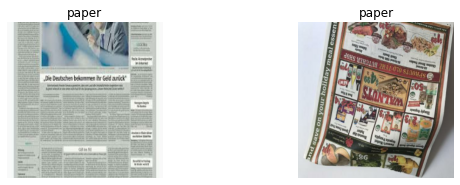

In [40]:
plt.figure(figsize=(20,20))
for image_batch,label_batch in load_data.take(1):
    for i in range(0,2):
        plt.subplot(6,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint32"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [41]:
def get_dataset_partition_tf(data,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    data_size=len(data)
    if shuffle:
        data=data.shuffle(shuffle_size,seed=12)
    train_size=int(train_split*data_size)
    val_size=int(val_split*data_size)
    train_data=data.take(train_size)
    
    val_data=data.skip(train_size).take(val_size)
    test_data=data.skip(train_size).skip(val_size)
    return train_data,val_data,test_data
    

In [42]:
train_data,val_data,test_data=get_dataset_partition_tf(load_data)

In [43]:
len(train_data)

336

In [44]:
len(val_data)

42

In [45]:
len(test_data)

43

In [46]:
train_data=train_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_data=val_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data=test_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [47]:
resize_and_rescale =tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1.0/255)  

])

In [48]:
data_augmentation =tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2)  

])

In [49]:
#for image, _ in train_ds.take(1):
 # plt.figure(figsize=(10, 10))
#  first_image = image[0]
 # for i in range(9):
  #  ax = plt.subplot(3, 3, i + 1)
   # augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    #plt.imshow(augmented_image[0] / 255)
    #plt.axis('off')

In [50]:
input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)

overall_model = models.Sequential([
    resize_and_rescale,#data_augmentation,
    layers.Conv2D(16,(3,3),activation = "relu", input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(32,kernel_size = (3,3),activation= "relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3),activation= "relu"),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(len(class_names),activation='softmax')

])


In [51]:
overall_model.build(input_shape=input_shape)

In [52]:
overall_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (6, 256, 256, 3)          0         
                                                                 
 conv2d_9 (Conv2D)           (6, 254, 254, 16)         448       
                                                                 
 max_pooling2d_9 (MaxPooling  (6, 127, 127, 16)        0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (6, 125, 125, 32)         4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (6, 62, 62, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (6, 60, 60, 64)          

In [53]:
overall_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']

)

In [54]:

history=overall_model.fit(
    train_data,
    epochs=10,
    batch_size=6,
    validation_data=val_data

)

Epoch 1/10
336/336 [==============================] - 15s 33ms/step - loss: 0.8582 - accuracy: 0.5615 - val_loss: 0.6578 - val_accuracy: 0.6706
Epoch 2/10
336/336 [==============================] - 7s 20ms/step - loss: 0.7070 - accuracy: 0.6711 - val_loss: 0.4844 - val_accuracy: 0.7897
Epoch 3/10
336/336 [==============================] - 7s 19ms/step - loss: 0.5168 - accuracy: 0.7713 - val_loss: 0.3884 - val_accuracy: 0.8413
Epoch 4/10
336/336 [==============================] - 7s 20ms/step - loss: 0.3418 - accuracy: 0.8601 - val_loss: 0.2897 - val_accuracy: 0.9127
Epoch 5/10
336/336 [==============================] - 7s 20ms/step - loss: 0.1900 - accuracy: 0.9251 - val_loss: 0.1725 - val_accuracy: 0.9325
Epoch 6/10
336/336 [==============================] - 7s 20ms/step - loss: 0.1937 - accuracy: 0.9306 - val_loss: 0.1671 - val_accuracy: 0.9325
Epoch 7/10
336/336 [==============================] - 7s 20ms/step - loss: 0.0837 - accuracy: 0.9712 - val_loss: 0.1167 - val_accuracy: 0.960

In [55]:
scores=overall_model.evaluate(test_data)

43/43 [==============================] - 4s 15ms/step - loss: 0.3180 - accuracy: 0.9535


In [34]:
#serial model
model_json = overall_model.to_json()
with open("2model.json","w") as json_file:
    json_file.write(model_json)

In [60]:
#serial weight
overall_model.save_weights("2model.h5")

In [ ]:
#load json model
json_file=open("model.json","r")
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

In [ ]:
#load weight
loaded_model.load_weights("model.h5")

Actual label :  trash
1/1 [==============================] - 0s 448ms/step
predicted label :  trash


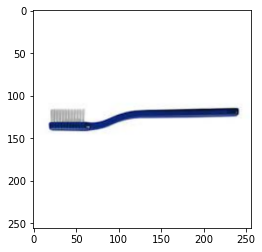

In [56]:
for image_batch,lables_batch in test_data.take(1):
    image=image_batch[0].numpy().astype("uint8")
    label=lables_batch[0].numpy()
    
    plt.imshow(image)
    print("Actual label : ",class_names[label])
    
    batch_prediction=overall_model.predict(image_batch)
    print("predicted label : ",class_names[np.argmax(batch_prediction[0])])

In [57]:
def predict (overall_model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(image[i].numpy())
    img_array = tf.expand_dims(img_array,0)
    
    prediction = overall_model.predict(img_array)
    predicted_class = class_names[np.argmax(prediction[0])]
    confidence = round(100*(np.max(prediction[0])),2)
    return predicted_class,confidence

1/1 [==============================] - 0s 30ms/step


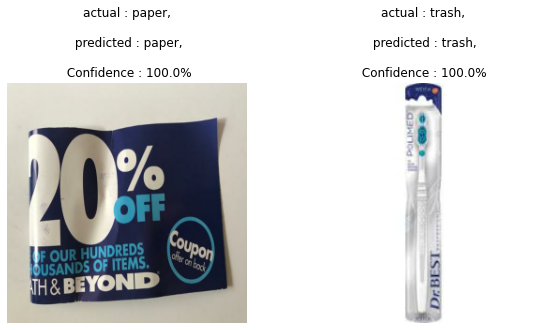

In [60]:
plt.figure(figsize=(15,15))
for image, labels in test_data.take(1):
    for i in range(2):
        
        plt.subplot(3,3,i+1)
        plt.imshow(image[i].numpy().astype("uint8"))
        predicted_class,confidence= predict(overall_model,image[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"actual : {actual_class},\n\n predicted : {predicted_class},\n\n Confidence : {confidence}%")
        plt.axis("off")

In [59]:
nvidia-smi

NameError: name 'nvidia' is not defined

In [ ]:
#tf.__version__
#from tensorflow.keras.preprocessing import image
#from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
#import numpy as np


In [ ]:
#pip install tensorflow==2.9

In [ ]:
#pip uninstall tensorflow

In [ ]:
#pip install --upgrade matplotlib

42/42 - 1s - loss: 0.2087 - accuracy: 0.9603 - 563ms/epoch - 13ms/step


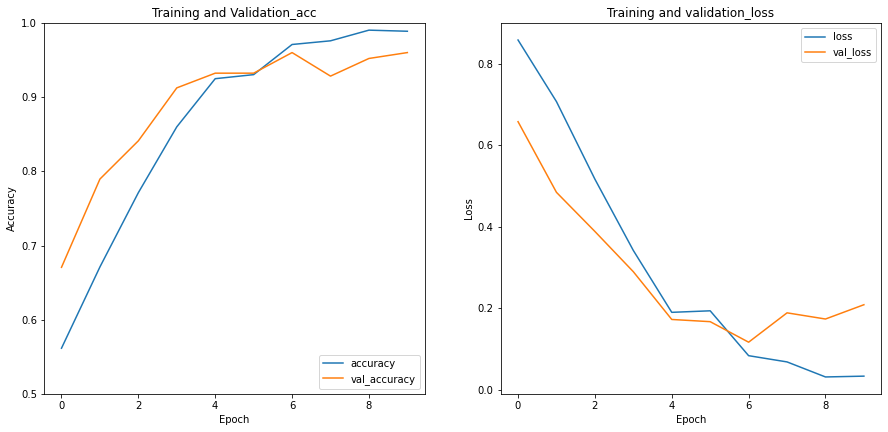

In [61]:
plt.figure(figsize=(15,15))
plt.subplot(2,2,1)

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title("Training and Validation_acc")
plt.legend(loc='lower right')

plt.subplot(2,2,2)
plt.plot(history.history["loss"],label="loss")
plt.plot(history.history["val_loss"],label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and validation_loss")
plt.legend(loc='upper right')

test_loss, test_acc = overall_model.evaluate(val_data, verbose=2)